# Research Compass

# GNN

## U00363568

### AYUSH CHHOKER

### Group - 6


# GNN Classification on OGB arXiv Dataset

Implementing and comparing Graph Attention Networks (GAT), Graph Convolutional Networks (GCN), and GraphSAGE for paper classification on the OGB arXiv citation network.

**Dataset:** 169,343 Computer Science papers, 40 subject areas, 1.17M citations

**Objective:** Predict research subject area based on citation patterns and paper features.

## Setup and Installation

Installing required libraries for PyTorch, PyTorch Geometric, and OGB.

In [ ]:
!pip install -q torch torchvision
!pip install -q torch-geometric
!pip install -q ogb
!pip install -q matplotlib seaborn pandas numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Running on: cuda
GPU: Tesla T4


## Loading Dataset

Loading the OGB arXiv citation network dataset.

In [ ]:
# Apply PyTorch 2.6+ serialization compatibility fix
# Required for newer PyTorch versions when loading OGB datasets
try:
    import torch.serialization
    from torch_geometric.data.data import DataTensorAttr, DataEdgeAttr
    from torch_geometric.data.storage import GlobalStorage, NodeStorage, EdgeStorage

    # Add all required PyTorch Geometric classes to safe globals
    torch.serialization.add_safe_globals([
        DataTensorAttr,
        DataEdgeAttr,
        GlobalStorage,
        NodeStorage,
        EdgeStorage
    ])
    print("Applied PyTorch 2.6+ compatibility fix")
except (AttributeError, ImportError) as e:
    print(f"Compatibility fix not needed for this PyTorch version: {type(e).__name__}")
    pass

Applied PyTorch 2.6+ compatibility fix


In [ ]:
from ogb.nodeproppred import PygNodePropPredDataset

print("Downloading OGB arXiv dataset...")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='/tmp/ogb')
data = dataset[0]
split_idx = dataset.get_idx_split()

# masks for train/val/test
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[split_idx['train']] = True

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[split_idx['valid']] = True

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[split_idx['test']] = True

# Flatten labels - they come as (N, 1) need (N,)
data.y = data.y.squeeze(1)

print(f"\nDataset loaded!")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Features: {data.num_features}")
print(f"  Classes: {dataset.num_classes}")
print(f"  Train: {split_idx['train'].shape[0]:,}")
print(f"  Val: {split_idx['valid'].shape[0]:,}")
print(f"  Test: {split_idx['test'].shape[0]:,}")

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:03<00:00, 21.13it/s]


Extracting /tmp/ogb/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 9915.61it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1307.86it/s]

Saving...



Done!



Dataset loaded!
  Nodes: 169,343
  Edges: 1,166,243
  Features: 128
  Classes: 40
  Train: 90,941
  Val: 29,799
  Test: 48,603


## Model Architectures

Implementing three different GNN architectures for comparison.

In [ ]:
class GAT(nn.Module):
    """Graph Attention Network with multi-head attention"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(nn.Module):
    """GraphSAGE with neighborhood aggregation"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("Models defined successfully!")

Models defined successfully!


## Training Setup

Training loop with early stopping based on validation accuracy.

In [ ]:
def train_model(model, data, model_name, epochs=200, lr=0.01, weight_decay=5e-4, patience=40):
    """Train model with early stopping based on validation accuracy"""
    model = model.to(device)
    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.NLLLoss()

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    train_losses = []
    val_accs = []

    print(f"\nTraining {model_name}...")
    print("-" * 50)

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum().item()
            val_acc = val_correct / data.val_mask.sum().item()

        train_losses.append(loss.item())
        val_accs.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Best: {best_val_acc:.4f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    # Load best model weights
    model.load_state_dict(best_model_state)
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return model, train_losses, val_accs

def evaluate_model(model, data):
    """Evaluate model on test set"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
        test_acc = test_correct / data.test_mask.sum().item()

        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )

    return test_acc, precision, recall, f1, y_true, y_pred

## Training Models

Training all three GNN architectures and comparing their performance.

### GAT (Graph Attention Network)

In [ ]:
gat = GAT(data.num_features, 128, dataset.num_classes, heads=2, dropout=0.5)
gat_model, gat_losses, gat_val_accs = train_model(gat, data, 'GAT', epochs=200, lr=0.005)
gat_test_acc, gat_precision, gat_recall, gat_f1, gat_y_true, gat_y_pred = evaluate_model(gat_model, data)

print(f"\nGAT Test Results:")
print(f"  Accuracy:  {gat_test_acc:.4f}")
print(f"  Precision: {gat_precision:.4f}")
print(f"  Recall:    {gat_recall:.4f}")
print(f"  F1 Score:  {gat_f1:.4f}")


Training GAT...
--------------------------------------------------
Epoch  20 | Loss: 2.7201 | Val Acc: 0.4762 | Best: 0.4762
Epoch  40 | Loss: 2.4812 | Val Acc: 0.5440 | Best: 0.5440
Epoch  60 | Loss: 2.4157 | Val Acc: 0.5549 | Best: 0.5549
Epoch  80 | Loss: 2.3808 | Val Acc: 0.5560 | Best: 0.5576
Epoch 100 | Loss: 2.3644 | Val Acc: 0.5592 | Best: 0.5611
Epoch 120 | Loss: 2.3504 | Val Acc: 0.5596 | Best: 0.5611
Epoch 140 | Loss: 2.3356 | Val Acc: 0.5593 | Best: 0.5617
Epoch 160 | Loss: 2.3264 | Val Acc: 0.5588 | Best: 0.5617

Early stopping triggered at epoch 165
Best validation accuracy: 0.5617

GAT Test Results:
  Accuracy:  0.5124
  Precision: 0.5170
  Recall:    0.5124
  F1 Score:  0.4879


### GCN (Graph Convolutional Network)

In [ ]:
gcn = GCN(data.num_features, 256, dataset.num_classes, dropout=0.5)
gcn_model, gcn_losses, gcn_val_accs = train_model(gcn, data, 'GCN', epochs=200, lr=0.01)
gcn_test_acc, gcn_precision, gcn_recall, gcn_f1, gcn_y_true, gcn_y_pred = evaluate_model(gcn_model, data)

print(f"\nGCN Test Results:")
print(f"  Accuracy:  {gcn_test_acc:.4f}")
print(f"  Precision: {gcn_precision:.4f}")
print(f"  Recall:    {gcn_recall:.4f}")
print(f"  F1 Score:  {gcn_f1:.4f}")


Training GCN...
--------------------------------------------------
Epoch  20 | Loss: 2.2219 | Val Acc: 0.4988 | Best: 0.4988
Epoch  40 | Loss: 1.9058 | Val Acc: 0.5436 | Best: 0.5436
Epoch  60 | Loss: 1.8306 | Val Acc: 0.5596 | Best: 0.5596
Epoch  80 | Loss: 1.7910 | Val Acc: 0.5629 | Best: 0.5644
Epoch 100 | Loss: 1.7692 | Val Acc: 0.5673 | Best: 0.5682
Epoch 120 | Loss: 1.7654 | Val Acc: 0.5681 | Best: 0.5709
Epoch 140 | Loss: 1.7512 | Val Acc: 0.5676 | Best: 0.5715
Epoch 160 | Loss: 1.7439 | Val Acc: 0.5693 | Best: 0.5732
Epoch 180 | Loss: 1.7392 | Val Acc: 0.5698 | Best: 0.5732

Early stopping triggered at epoch 184
Best validation accuracy: 0.5732

GCN Test Results:
  Accuracy:  0.5069
  Precision: 0.5213
  Recall:    0.5069
  F1 Score:  0.4890


### GraphSAGE

In [ ]:
sage = GraphSAGE(data.num_features, 256, dataset.num_classes, dropout=0.5)
sage_model, sage_losses, sage_val_accs = train_model(sage, data, 'GraphSAGE', epochs=200, lr=0.01)
sage_test_acc, sage_precision, sage_recall, sage_f1, sage_y_true, sage_y_pred = evaluate_model(sage_model, data)

print(f"\nGraphSAGE Test Results:")
print(f"  Accuracy:  {sage_test_acc:.4f}")
print(f"  Precision: {sage_precision:.4f}")
print(f"  Recall:    {sage_recall:.4f}")
print(f"  F1 Score:  {sage_f1:.4f}")


Training GraphSAGE...
--------------------------------------------------
Epoch  20 | Loss: 2.1591 | Val Acc: 0.4679 | Best: 0.4679
Epoch  40 | Loss: 1.8314 | Val Acc: 0.5442 | Best: 0.5442
Epoch  60 | Loss: 1.7496 | Val Acc: 0.5628 | Best: 0.5628
Epoch  80 | Loss: 1.7167 | Val Acc: 0.5673 | Best: 0.5688
Epoch 100 | Loss: 1.6981 | Val Acc: 0.5713 | Best: 0.5733
Epoch 120 | Loss: 1.6810 | Val Acc: 0.5745 | Best: 0.5759
Epoch 140 | Loss: 1.6744 | Val Acc: 0.5735 | Best: 0.5785
Epoch 160 | Loss: 1.6675 | Val Acc: 0.5792 | Best: 0.5801
Epoch 180 | Loss: 1.6620 | Val Acc: 0.5770 | Best: 0.5801
Epoch 200 | Loss: 1.6564 | Val Acc: 0.5819 | Best: 0.5819
Best validation accuracy: 0.5819

GraphSAGE Test Results:
  Accuracy:  0.5186
  Precision: 0.5317
  Recall:    0.5186
  F1 Score:  0.5000


## Results Comparison

Comparing performance metrics across all three models.

In [ ]:
# Create results summary table
results_df = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test Accuracy': [gat_test_acc, gcn_test_acc, sage_test_acc],
    'Precision': [gat_precision, gcn_precision, sage_precision],
    'Recall': [gat_recall, gcn_recall, sage_recall],
    'F1 Score': [gat_f1, gcn_f1, sage_f1]
})

print("\n" + "="*70)
print("FINAL RESULTS - OGB arXiv Dataset")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)


FINAL RESULTS - OGB arXiv Dataset
    Model  Test Accuracy  Precision   Recall  F1 Score
      GAT       0.512355   0.517037 0.512355  0.487913
      GCN       0.506923   0.521313 0.506923  0.488977
GraphSAGE       0.518589   0.531695 0.518589  0.500045


## Visualizations

Plotting training dynamics and model performance.

## Visualizations

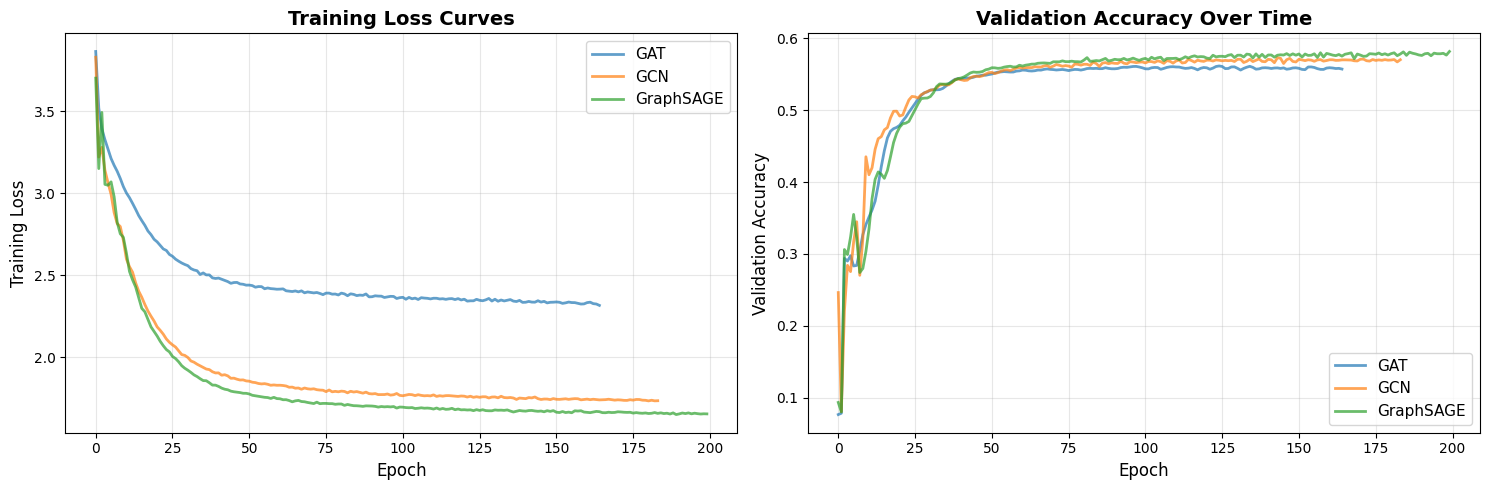

In [ ]:
# Plot training dynamics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training loss
axes[0].plot(gat_losses, label='GAT', linewidth=2, alpha=0.7)
axes[0].plot(gcn_losses, label='GCN', linewidth=2, alpha=0.7)
axes[0].plot(sage_losses, label='GraphSAGE', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Validation accuracy
axes[1].plot(gat_val_accs, label='GAT', linewidth=2, alpha=0.7)
axes[1].plot(gcn_val_accs, label='GCN', linewidth=2, alpha=0.7)
axes[1].plot(sage_val_accs, label='GraphSAGE', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Saving Models

Saving trained models and results for later use.

In [ ]:
# Save all trained models and results
torch.save({
    'gat_state': gat_model.state_dict(),
    'gcn_state': gcn_model.state_dict(),
    'sage_state': sage_model.state_dict(),
    'results': results_df.to_dict(),
    'dataset_info': {
        'num_features': data.num_features,
        'num_classes': dataset.num_classes,
        'num_nodes': data.num_nodes,
        'num_edges': data.num_edges
    }
}, 'ogb_arxiv_models.pt')

print("\nAll models and results saved to 'ogb_arxiv_models.pt'")
print("\nTraining complete!")


All models and results saved to 'ogb_arxiv_models.pt'

Training complete!
